# Libraries and Data Import
Also have a quick look at the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
repository_directory = "../"

In [21]:
df_source = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv", parse_dates=["date"])
df_source.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-01-01,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,213166608.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-01,Z305B2QN,ST4000DM000,4000787030016,0,114.0,79306032.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-01,ZLW0C6NE,ST12000NM001G,12000138625024,0,72.0,17162816.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,100.0,1102160.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-01,ZLW18MKT,ST14000NM001G,14000519643136,0,75.0,33233248.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_source.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date                165512 non-null  object 
 1   serial_number       165512 non-null  object 
 2   model               165512 non-null  object 
 3   capacity_bytes      165512 non-null  int64  
 4   failure             165512 non-null  int64  
 5   smart_1_normalized  165394 non-null  float64
 6   smart_1_raw         165394 non-null  float64
 7   smart_2_normalized  62489 non-null   float64
 8   smart_2_raw         62489 non-null   float64
 9   smart_3_normalized  164256 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 12.6+ MB


In [4]:
df_source.nunique()

date                         1
serial_number           165512
model                       59
capacity_bytes              15
failure                      2
                         ...  
smart_252_raw                0
smart_254_normalized         2
smart_254_raw                1
smart_255_normalized         0
smart_255_raw                0
Length: 149, dtype: int64

In [7]:
df_source.groupby("failure").count()["serial_number"]

failure
0    165508
1         4
Name: serial_number, dtype: int64

# Some Useful Functions and Lists

In [73]:
# specify commonly used column names
column_name_all = df_source.columns
column_name_basic, column_name_smart = column_name_all[:5], column_name_all[5:]
column_name_smart_raw = pd.Index([c for c in column_name_smart if "raw" in c ])
column_name_smart_normalized = pd.Index([c for c in column_name_smart if "normalized" in c ])

# collections of important smart parameters from different sources
key_smart_backblaze = [5, 187, 188, 197, 198] # https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/
key_smart_wiki = [5, 10, 184, 187, 188, 196, 197, 198, 201] # https://en.wikipedia.org/wiki/S.M.A.R.T.
key_smart_ai_paper = [3, 5, 7, 187, 188, 190, 197, 198] # https://www.sciencedirect.com/science/article/pii/S2666827021000219
key_smart_power_on_time = [9]
key_smart = [3, 5, ]

def smart2meaningful(col):
    """smart to meaningful names
    see wiki for more info: https://en.wikipedia.org/wiki/S.M.A.R.T.

    Args:
        col (panda.Index): name of columns returned from a dataframe

    Returns:
        panda.Index: a column with more meaningful names
    """
    dict_smart = {3   : "spin_up_time",
                  5   : "reallocated_sector_count", # or "bad-sector count" 
                  7   : "seek_error_rate", # or "reading-head seek-error rate", vendor-dependent
                  9   : "power_on_time", 
                  10  : "spin_retry_count",
                  184 : "end_to_end_error", # vendor-dependent
                  187 : "reported_uncorrectable_error",
                  188 : "command_timeout_count",
                  190 : "temperature_special", # vendor-dependent
                  194 : "temperature",
                  196 : "reallocation_event_count",
                  197 : "current_pending_sector_count", # or "unusable sector count"
                  198 : "uncorrectable_sector_count", 
                  201 : "software_read_error_count", 
                  231 : "expected_life_left"
    }
    col_modified = []
    for name in list(col):
        if "smart_" in name:
            number = int(name.split("smart_")[1].split("_")[0])
            if number in list(dict_smart.keys()):
                col_modified.append(name.replace("smart_" + str(number), dict_smart[number]))
            else:
                col_modified.append(name)
        else:
            col_modified.append(name)
    return pd.Index(col_modified)

# change the smart name into meaningful names for a dataframe
# this should be applied only after you perform all operations on columns
def smart2meaningful_for_dataframe(df):
    df.columns = smart2meaningful(df.columns)
    return df

# drop all smart columns except those specified by smart_to_keep
def keep_some_smart_column_for_dataframe(df, smart_to_keep=[], raw_or_normalized="raw"):
    cols = df.columns
    cols_nonsmart = [col for col in cols if not "smart_" in col]
    #cols_smart = [col for col in cols if "smart_" in col]
    #s = set(cols_smart)
    cols_smart = ["smart_" + str(i) + "_" + raw_or_normalized for i in smart_to_keep]
    print(cols_smart)
    print(cols_nonsmart)
    return df[cols_nonsmart + cols_smart]

def change_feature_dtype_for_dataframe(df, feature_to_change=[]):
    col = df.columns
    for feature in feature_to_change:
        if not feature in col:
            print("### Error!")
            print(f"### The feature '{feature}' is not found in the dataframe '{df}'!")
            print("### Partially modified dataframe is returned!")
            return df
        if feature == "failure":
            df.astype({feature : "int64"})
        elif feature == "date":
            df[feature] = pd.to_datetime(df[feature], format='%Y-%m-%d')
    return df

# create features for a dataframe
def create_features_for_dataframe(df, features_to_create=[], drop=False):
    feature_to_drop = []
    col = df.columns
    for feature in features_to_create:
        if feature == "capacity_gb":
            features_needed = ["capacity_bytes"]
            for feature_needed in features_needed:
                if not feature_needed in col:
                    print("### Error!")
                    print(f"### Cannot create '{feature}' because the required feature '{feature_needed}' is not found in the dataframe '{df}'!")
                    print("### Partially modified dataframe is returned!")
                    return df
            gb2byte = 1024**3
            df[feature] = df[features_needed[0]].apply(lambda x : x/gb2byte)
            feature_to_drop.append(*features_needed)
        #elif feature == "power_on_time_day":
        #    df[feature] = df["power_on_time"].apply(lambda x : x/24)
        #    feature_to_drop.append("power_on_time")
    if drop:
        df.drop(list(set(feature_to_drop)), axis=1)
    return df

# EDA (one day)

In [74]:
df = pd.read_csv(repository_directory + "data/data_Q1_2021/2021-01-01.csv")

In [75]:
df = change_feature_dtype_for_dataframe(df, feature_to_change=["date"])
df = keep_some_smart_column_for_dataframe(df, smart_to_keep=[9], raw_or_normalized="raw")
#df = create_features_for_dataframe(df, features_to_create=["capacity_gb"], drop=True)
#df = smart2meaningful_for_dataframe(df)

['smart_9_raw']
['date', 'serial_number', 'model', 'capacity_bytes', 'failure']


In [76]:
df.head()
df.iloc[:,:10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165512 entries, 0 to 165511
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            165512 non-null  datetime64[ns]
 1   serial_number   165512 non-null  object        
 2   model           165512 non-null  object        
 3   capacity_bytes  165512 non-null  int64         
 4   failure         165512 non-null  int64         
 5   smart_9_raw     165394 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 7.6+ MB


In [54]:

df.query("failure==1")


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
11511,2021-01-01,ZHZ4ESP9,ST12000NM0008,12000138625024,1,70.0,10044608.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90728,2021-01-01,PL1331LAHD2YRH,HGST HMS5C4040BLE640,4000787030016,1,100.0,0.0,134.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118917,2021-01-01,ZJV4MDYR,ST12000NM0007,12000138625024,1,80.0,109242552.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130515,2021-01-01,40P0A0SVF97G,TOSHIBA MG07ACA14TA,14000519643136,1,100.0,0.0,100.0,0.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


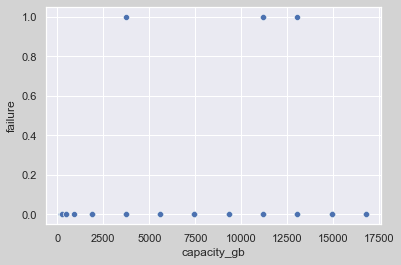

In [10]:
sns.set(rc={'figure.facecolor': "lightgray"})
ax = sns.scatterplot(data=df, x="capacity_gb", y="failure")

In [11]:
df.query("failure==1")

,date,serial_number,model,capacity_bytes,failure,capacity_gb
11511,2021-01-01,ZHZ4ESP9,ST12000NM0008,12000138625024,1,11176.000000
90728,2021-01-01,PL1331LAHD2YRH,HGST HMS5C4040BLE640,4000787030016,1,3726.023277
118917,2021-01-01,ZJV4MDYR,ST12000NM0007,12000138625024,1,11176.000000
130515,2021-01-01,40P0A0SVF97G,TOSHIBA MG07ACA14TA,14000519643136,1,13039.000000


In [12]:
# setup for reading time series
#serials = ['ZLW0EGC6', 'Z305B2QN', 'ZLW0C6NE', 'ZJV0XJQ3', 'ZLW18MKT', 'ZLW0GGTP']
serials = ['ZLW0EGC6', 'ZLW0GGTP']
start_date = "2021-01-11"
end_date = "2021-01-12"
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1
column_to_save = ['date', 'serial_number', 'model', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = ['date', 'capacity_bytes', 'failure', 'smart_1_normalized']
#column_to_save = column_name_all

# Prepare the DataFrame for Time Series

In [13]:
# create a list of empty dataframes for concatenation later
time_series_dataset = []
for serial in serials:
    time_series_dataset.append(pd.DataFrame([], columns=column_to_save))

memory_used = 0
memory_warning_displayed = False
print(f"Read files for building time series from {start_date} to {end_date}; totally {days} days; {len(serials)} serials")
for day in range(days):
    date = pd.Period(start_date) + day
    print(f"  reading data for the date {date}; progress: {day+1}/{days}")
    file_path = repository_directory + "data/data_Q1_2021/" + str(date) + ".csv"
    df_tmp = pd.read_csv(file_path, parse_dates=["date"])
    for i, serial in enumerate(serials):
        df_tmp_serial = df_tmp.query("serial_number == @serial")[column_to_save]
        time_series_dataset[i] = pd.concat([time_series_dataset[i], df_tmp_serial], ignore_index=True)
        memory_used += time_series_dataset[i].memory_usage(deep=True).sum()
    if memory_used/1024**3 > 1 and not memory_warning_displayed:
        print(" ### Warning: memory used for time-series dataframe > 1 GB ###")
        memory_warning_displayed = True

print("Time series was read successfully")
print(f"Memory used for dataframe: {(memory_used/1024**3).round(3)} GB")

Read files for building time series from 2021-01-11 to 2021-01-12; totally 2 days; 2 serials
  reading data for the date 2021-01-11; progress: 1/2
  reading data for the date 2021-01-12; progress: 2/2
Time series was read successfully
Memory used for dataframe: 0.0 GB


In [14]:
# check the dataframe of a HDD specified by choice
choice = 1
time_series_dataset[choice].head(5)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized
0,2021-01-11,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0
1,2021-01-12,ZLW0GGTP,ST12000NM001G,12000138625024,0,83.0


In [15]:
time_series_dataset[choice].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2 non-null      datetime64[ns]
 1   serial_number       2 non-null      object        
 2   model               2 non-null      object        
 3   capacity_bytes      2 non-null      object        
 4   failure             2 non-null      object        
 5   smart_1_normalized  2 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 224.0+ bytes


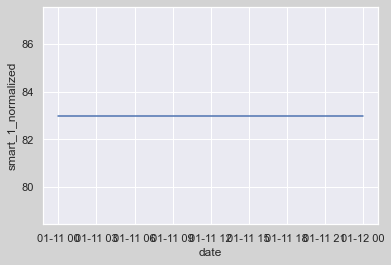

In [16]:
sns.set(rc={'figure.facecolor': "lightgray"})
ax = sns.lineplot(data=time_series_dataset[choice], x="date", y="smart_1_normalized")

In [17]:
print("Save read time series to csv files")
for i, serial in enumerate(serials):
    file_path = repository_directory + "data/time_series/" + serial + "_" + start_date + "_to_" + end_date + ".csv" 
    time_series_dataset[i].to_csv(file_path)
    print(f"  save to \"{file_path}\"; progress {i}/{len(serials)}")
print("Time series are saved successfully")

Save read time series to csv files
  save to "../data/time_series/ZLW0EGC6_2021-01-11_to_2021-01-12.csv"; progress 0/2
  save to "../data/time_series/ZLW0GGTP_2021-01-11_to_2021-01-12.csv"; progress 1/2
Time series are saved successfully


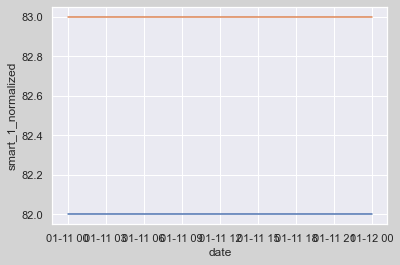

In [18]:
sns.set(rc={'figure.facecolor': "lightgray"})
for i, serial in enumerate(serials):
    ax = sns.lineplot(data=time_series_dataset[i], x="date", y="smart_1_normalized")

# EDA

In [19]:
# check the most frequent model
pd.unique(df_source["model"])
df_source.groupby("model").count().sort_values(by="serial_number", ascending=False).head(3)

,date,serial_number,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
model,,,,,,,,,,,,,,,,,,,,,
ST12000NM0007,23036,23036,23036,23036,23036,23036,0,0,23036,23036,...,0,0,0,0,0,0,0,0,0,0
TOSHIBA MG07ACA14TA,21027,21027,21027,21027,21027,21027,21027,21027,21027,21027,...,0,0,0,0,0,0,0,0,0,0
ST12000NM0008,19287,19287,19287,19287,19287,19287,0,0,19287,19287,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# setup for reading time series
hd_model = "ST12000NM0007"
start_date = "2021-01-01"
end_date = "2021-03-31"


# set up the actual smart parameters to save
key_smart = key_smart_ai_paper + key_smart_power_on_time
select_raw_or_normalized = "raw"
column_to_save = list(column_name_basic)
smart_number_in_string = ["_" + str(i) + "_" for i in key_smart]
for item in column_name_smart:
    #print(item)
    for i in smart_number_in_string:
        if (i in item) and (select_raw_or_normalized in item):
            column_to_save.append(item)
column_to_save = pd.Index(column_to_save)
print("Column saved: \n", column_to_save)
days = pd.Period(end_date).dayofyear - pd.Period(start_date).dayofyear + 1

Column saved: 
 Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_3_raw', 'smart_5_raw', 'smart_7_raw', 'smart_9_raw',
       'smart_187_raw', 'smart_188_raw', 'smart_190_raw', 'smart_197_raw',
       'smart_198_raw'],
      dtype='object')


In [22]:
# create a list of empty dataframes for concatenation later
df_hd_model_failure = pd.DataFrame([], columns=column_to_save)

memory_used = 0
memory_warning_displayed = False
print(f"Read files from {start_date} to {end_date}; totally {days} days; {len(serials)} serials")
for day in range(days):
    date = pd.Period(start_date) + day
    print(f"  reading data for the date {date}; progress: {day+1}/{days}")
    file_path = repository_directory + "data/data_Q1_2021/" + str(date) + ".csv"
    df_tmp = pd.read_csv(file_path, parse_dates=["date"])
    df_failure = df_tmp.query("model == @hd_model and failure == 1")[column_to_save]
    df_hd_model_failure = pd.concat([df_hd_model_failure, df_failure], ignore_index=True)
    memory_used += df_hd_model_failure.memory_usage(deep=True).sum()
    if memory_used/1024**3 > 1 and not memory_warning_displayed:
        print(" ### Warning: memory used for time-series dataframe > 1 GB ###")
        memory_warning_displayed = True

print("Number of rows:", len(df_hd_model_failure))
print("Dataframe for failed hds was read successfully")
print(f"Memory used for dataframe: {(memory_used/1024**3).round(3)} GB")

Read files from 2021-01-01 to 2021-03-31; totally 90 days; 2 serials
  reading data for the date 2021-01-01; progress: 1/90
  reading data for the date 2021-01-02; progress: 2/90
  reading data for the date 2021-01-03; progress: 3/90
  reading data for the date 2021-01-04; progress: 4/90
  reading data for the date 2021-01-05; progress: 5/90
  reading data for the date 2021-01-06; progress: 6/90
  reading data for the date 2021-01-07; progress: 7/90
  reading data for the date 2021-01-08; progress: 8/90
  reading data for the date 2021-01-09; progress: 9/90
  reading data for the date 2021-01-10; progress: 10/90
  reading data for the date 2021-01-11; progress: 11/90
  reading data for the date 2021-01-12; progress: 12/90
  reading data for the date 2021-01-13; progress: 13/90
  reading data for the date 2021-01-14; progress: 14/90
  reading data for the date 2021-01-15; progress: 15/90
  reading data for the date 2021-01-16; progress: 16/90
  reading data for the date 2021-01-17; prog

In [23]:
df_hd_model_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            66 non-null     datetime64[ns]
 1   serial_number   66 non-null     object        
 2   model           66 non-null     object        
 3   capacity_bytes  66 non-null     object        
 4   failure         66 non-null     object        
 5   smart_3_raw     63 non-null     float64       
 6   smart_5_raw     63 non-null     float64       
 7   smart_7_raw     63 non-null     float64       
 8   smart_9_raw     63 non-null     float64       
 9   smart_187_raw   63 non-null     float64       
 10  smart_188_raw   63 non-null     float64       
 11  smart_190_raw   63 non-null     float64       
 12  smart_197_raw   63 non-null     float64       
 13  smart_198_raw   63 non-null     float64       
dtypes: datetime64[ns](1), float64(9), object(4)
memory usage: 7.

In [24]:
df_hd_model_failure.nunique()

date              43
serial_number     66
model              1
capacity_bytes     1
failure            1
smart_3_raw        1
smart_5_raw       45
smart_7_raw       63
smart_9_raw       63
smart_187_raw     44
smart_188_raw      9
smart_190_raw     22
smart_197_raw     18
smart_198_raw     18
dtype: int64

In [25]:
serial_failure = df_hd_model_failure["serial_number"]
print(serial_failure)

0     ZJV4MDYR
1     ZCH07WP7
2     ZCH0DG4W
3     ZJV4LWRR
4     ZCH07HR7
        ...   
61    ZJV2EMKA
62    ZJV0XZ82
63    ZJV3A0BA
64    ZCH0110Y
65    ZJV3C3B2
Name: serial_number, Length: 66, dtype: object


In [26]:
print("Save dataframe for failed hds to csv files")
file_path = repository_directory + "data/hd_failure_" + start_date + "_to_" + end_date + ".csv" 
df_hd_model_failure.to_csv(file_path, index=False)
print(f"Dataframe is saved successfully at  \"{file_path}\"")

Save dataframe for failed hds to csv files
Dataframe is saved successfully at  "../data/hd_failure_2021-01-01_to_2021-03-31.csv"


In [73]:
df_tmp = pd.read_csv(file_path, parse_dates=["date"])
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            66 non-null     datetime64[ns]
 1   serial_number   66 non-null     object        
 2   model           66 non-null     object        
 3   capacity_bytes  66 non-null     int64         
 4   failure         66 non-null     int64         
 5   smart_3_raw     63 non-null     float64       
 6   smart_5_raw     63 non-null     float64       
 7   smart_7_raw     63 non-null     float64       
 8   smart_9_raw     63 non-null     float64       
 9   smart_187_raw   63 non-null     float64       
 10  smart_188_raw   63 non-null     float64       
 11  smart_190_raw   63 non-null     float64       
 12  smart_197_raw   63 non-null     float64       
 13  smart_198_raw   63 non-null     float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory

In [55]:
# randomly get some healthy hds for balancing the data
RSEED = 40
df_hd_model_healthy = df_source[~df_source["serial_number"].isin(serial_failure)].query("model == @hd_model").sample(len(df_hd_model_failure), random_state=RSEED)[column_to_save]
df_hd_model_healthy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 146000 to 98945
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            66 non-null     datetime64[ns]
 1   serial_number   66 non-null     object        
 2   model           66 non-null     object        
 3   capacity_bytes  66 non-null     int64         
 4   failure         66 non-null     int64         
 5   smart_3_raw     66 non-null     float64       
 6   smart_5_raw     66 non-null     float64       
 7   smart_7_raw     66 non-null     float64       
 8   smart_9_raw     66 non-null     float64       
 9   smart_187_raw   66 non-null     float64       
 10  smart_188_raw   66 non-null     float64       
 11  smart_190_raw   66 non-null     float64       
 12  smart_197_raw   66 non-null     float64       
 13  smart_198_raw   66 non-null     float64       
dtypes: datetime64[ns](1), float64(9), int64(2), object(2

In [78]:
# concat the healthy and failed hd data

df_hd_model = pd.concat([df_hd_model_healthy, df_hd_model_failure], ignore_index=True)
#df_hd_model.nunique()

## Data cleaning


In [79]:
df_hd_model["capacity_gb"] = df_hd_model["capacity_bytes"].apply(lambda x : int(x)/gb2byte)
df_hd_model["failure"] = df_hd_model["failure"].apply(lambda x : int(x))

In [80]:
df_hd_model.drop(["model", "capacity_bytes"], axis=1, inplace=True)
df_hd_model = df_hd_model.dropna()

In [81]:
#meaningful_names = ["spin_up_time", ads]
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 131
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           129 non-null    datetime64[ns]
 1   serial_number  129 non-null    object        
 2   failure        129 non-null    int64         
 3   smart_3_raw    129 non-null    float64       
 4   smart_5_raw    129 non-null    float64       
 5   smart_7_raw    129 non-null    float64       
 6   smart_9_raw    129 non-null    float64       
 7   smart_187_raw  129 non-null    float64       
 8   smart_188_raw  129 non-null    float64       
 9   smart_190_raw  129 non-null    float64       
 10  smart_197_raw  129 non-null    float64       
 11  smart_198_raw  129 non-null    float64       
 12  capacity_gb    129 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 14.1+ KB


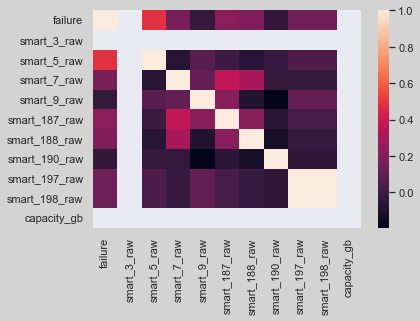

In [82]:
correlation = df_hd_model.corr()
ax = sns.heatmap(correlation)

In [93]:
correlation

,failure,smart_3_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_197_raw,smart_198_raw,capacity_gb
failure,1.000000,NaN,0.484475,0.166536,-0.027968,0.221913,0.191448,-0.031826,0.141386,0.141386,NaN
smart_3_raw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_5_raw,0.484475,NaN,1.000000,-0.068325,0.082732,0.000812,-0.065799,-0.027921,0.051119,0.051119,NaN
smart_7_raw,0.166536,NaN,-0.068325,1.000000,0.115838,0.373303,0.304595,-0.027160,-0.024322,-0.024322,NaN
smart_9_raw,-0.027968,NaN,0.082732,0.115838,1.000000,0.215172,-0.089453,-0.194701,0.109857,0.109857,NaN
smart_187_raw,0.221913,NaN,0.000812,0.373303,0.215172,1.000000,0.213459,-0.058494,0.029185,0.029185,NaN
smart_188_raw,0.191448,NaN,-0.065799,0.304595,-0.089453,0.213459,1.000000,-0.118084,-0.022946,-0.022946,NaN
smart_190_raw,-0.031826,NaN,-0.027921,-0.027160,-0.194701,-0.058494,-0.118084,1.000000,-0.045308,-0.045308,NaN
smart_197_raw,0.141386,NaN,0.051119,-0.024322,0.109857,0.029185,-0.022946,-0.045308,1.000000,1.000000,NaN
smart_198_raw,0.141386,NaN,0.051119,-0.024322,0.109857,0.029185,-0.022946,-0.045308,1.000000,1.000000,NaN


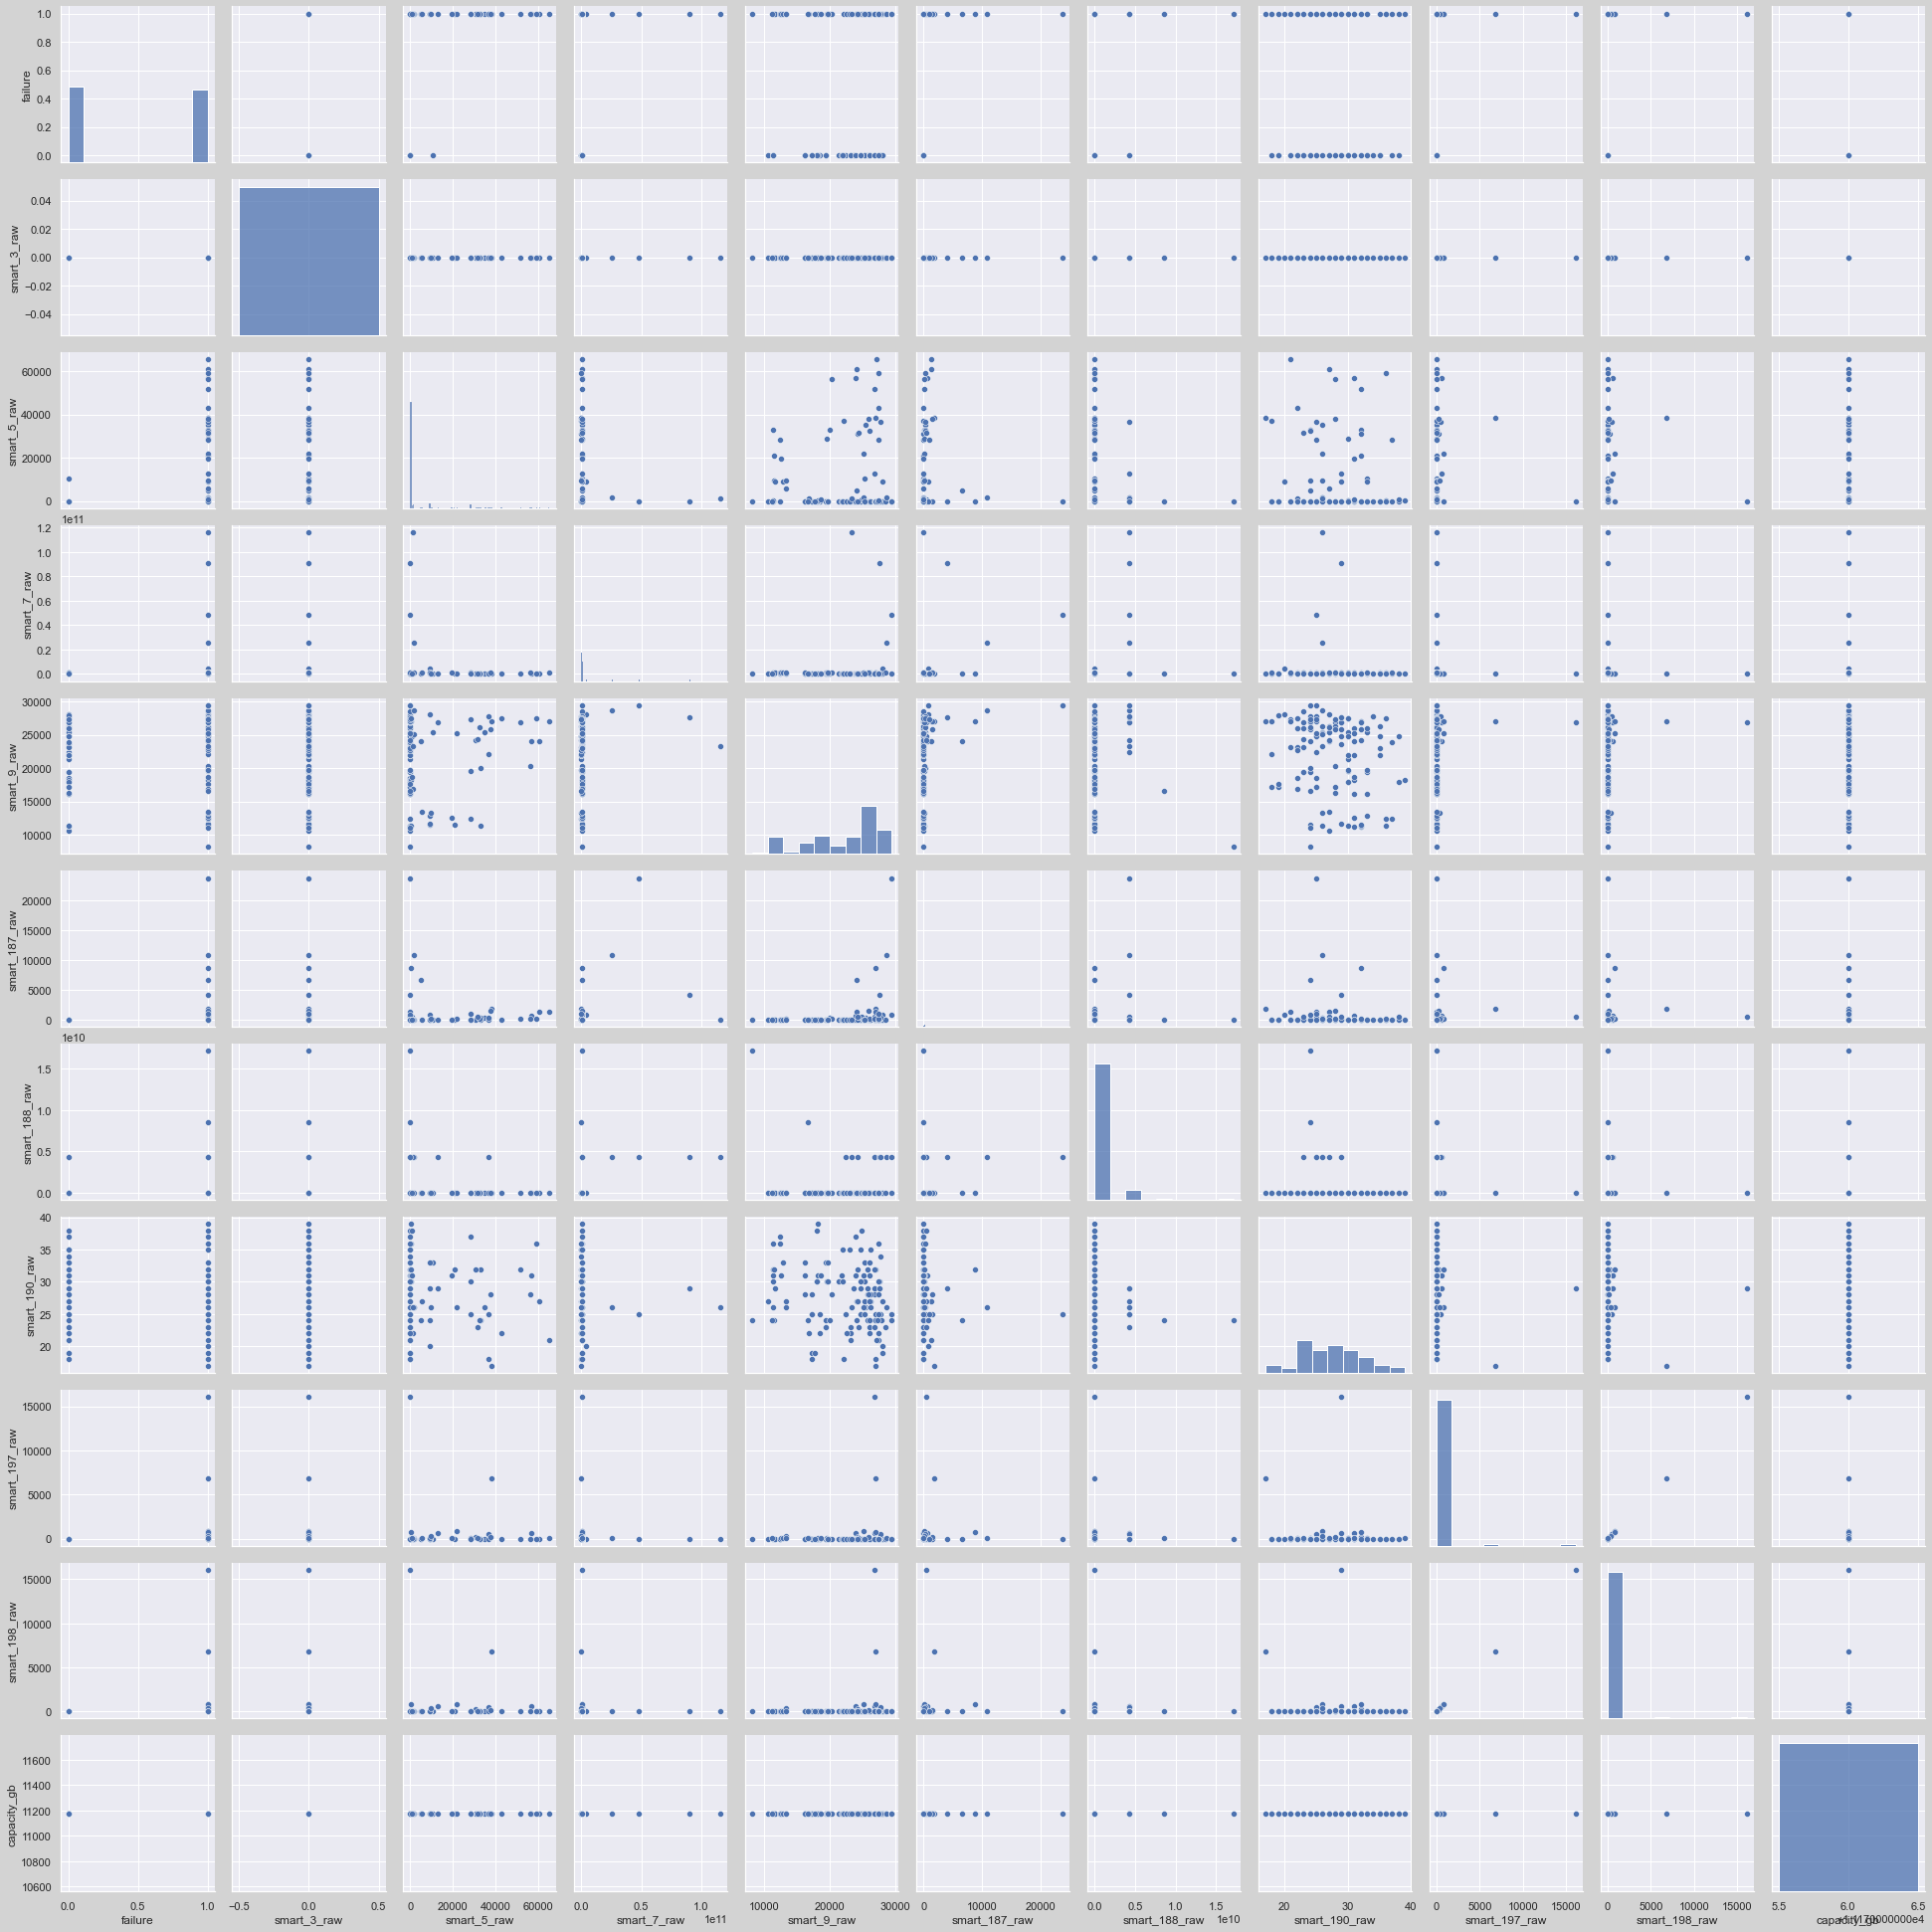

In [83]:
ax = sns.pairplot(data=df_hd_model)

In [99]:
from sklearn.feature_selection import mutual_info_classif

entropy = mutual_info_classif(df_hd_model[["smart_5_raw", "smart_7_raw", "smart_9_raw", "smart_187_raw", "smart_188_raw", "smart_190_raw", "smart_197_raw", "smart_198_raw", "capacity_gb"]], df_hd_model["failure"], random_state=100)

In [100]:
entropy

array([0.31521963, 0.02978993, 0.18079568, 0.29907047, 0.02965421,
       0.02191428, 0.16545779, 0.17785167, 0.02469974])

In [96]:
df_hd_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 131
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           129 non-null    datetime64[ns]
 1   serial_number  129 non-null    object        
 2   failure        129 non-null    int64         
 3   smart_3_raw    129 non-null    float64       
 4   smart_5_raw    129 non-null    float64       
 5   smart_7_raw    129 non-null    float64       
 6   smart_9_raw    129 non-null    float64       
 7   smart_187_raw  129 non-null    float64       
 8   smart_188_raw  129 non-null    float64       
 9   smart_190_raw  129 non-null    float64       
 10  smart_197_raw  129 non-null    float64       
 11  smart_198_raw  129 non-null    float64       
 12  capacity_gb    129 non-null    float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 18.2+ KB
